<a href="https://colab.research.google.com/github/gimb99/gbgTPDI/blob/develop/ejercicioIntegrador2/ejercicioIntegrador2_Entregable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalar la versión CORRECTA de OpenCV y luego importar

# Desinstalar primero para evitar conflictos (el -y evita la pregunta de confirmación)
!pip uninstall opencv-python -y
!pip uninstall opencv-contrib-python -y # Asegurarse de quitar ambas si existen

# Instalar la versión que incluye los módulos contrib
!pip install opencv-contrib-python

# --- IMPORTANTE ---
# Después de ejecutar esta celda, DEBES REINICIAR EL ENTORNO DE EJECUCIÓN.
# En Colab: Ve a "Entorno de ejecución" -> "Reiniciar entorno de ejecución..."
# Luego, vuelve a ejecutar todas las celdas desde el principio.
# ------------------

Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Successfully uninstalled opencv-contrib-python-4.11.0.86
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.4 MB/s eta 0:00:00


# Laboratorio Integrador: Detección de Rostros y Puntos Faciales Clave (Landmarks)

**Objetivo:** En esta práctica integradora, aplicaremos y conectaremos dos técnicas importantes de Visión por Computadora que hemos visto:

1.  **Detección de Rostros:** Utilizaremos el método de Haar Cascades para encontrar la ubicación de múltiples caras dentro de una imagen.
2.  **Detección de Landmarks Faciales:** Una vez localizadas las caras, aplicaremos un modelo más avanzado (LBF) para identificar 68 puntos clave específicos en cada rostro (ojos, cejas, nariz, boca, mandíbula).

**Contexto:** Estas técnicas son fundamentales en muchas aplicaciones, desde filtros de redes sociales y sistemas de reconocimiento facial hasta análisis de expresiones o detección de somnolencia en conductores.

**Imagen de Trabajo:** Usaremos una imagen obtenida en unas vacacioens a Maceió con mi pareja. Nada fuera de lo comun pero nos aporta claridad

**¡Manos a la obra!**

## Sección 0: Configuración del Entorno

Antes de comenzar, necesitamos asegurarnos de tener las librerías adecuadas y descargar los archivos necesarios (imagen, modelos pre-entrenados).

### 0.1 Instalación e Importación de Librerías

*   **`opencv-python` (`cv2`):** Librería esencial para visión por computadora.
*   **`opencv-contrib-python`:** Contiene módulos extra de OpenCV, incluyendo `cv2.face` que usaremos para los landmarks. A menudo, instalar este paquete reemplaza o incluye `opencv-python`.
*   **`matplotlib.pyplot` (`plt`):** Para visualizar imágenes dentro del cuaderno.
*   **`numpy` (`np`):** Para manejo eficiente de arrays (las imágenes son arrays).

In [2]:
# Instalar librerías (si es necesario) y luego importar
# Usamos %%capture para ocultar la salida detallada de la instalación.
#%%capture
#!pip uninstall opencv-python -y # Desinstalar versión base si existe
#!pip install matplotlib opencv-contrib-python # Instalar versión con módulos extra

import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Librerías importadas.")

Librerías importadas.


### 0.2 Descarga de Recursos

Descargaremos:

1.  **Imagen:** `sample4.jpg`.
2.  **Clasificador Haar:** `haarcascade_frontalface_default.xml`. Lo descargaremos directamente del repositorio oficial de OpenCV en GitHub. Este archivo contiene los patrones Haar pre-calculados para detectar rostros frontales.
3.  **Modelo de Landmarks LBF:** `lbfmodel.yaml`. Este es un modelo pre-entrenado específico para el algoritmo LBF (Local Binary Features) de detección de landmarks. (Usaremos el enlace del cuaderno original, ya que es una fuente común para este archivo específico). *Nota: Este archivo es grande (~70Mb) y puede tardar un poco.*

In [4]:
# Descargar archivos necesarios

# Descargar clasificador Haar desde el repositorio oficial de OpenCV
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -O haarcascade_frontalface_default.xml
print("Clasificador Haar descargado.\n")

# Descargar modelo de landmarks LBF (puede tardar)
# Usamos %%capture para ocultar la salida si es muy larga
#%%capture
!wget https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml -O lbfmodel.yaml
print("Modelo LBF para landmarks descargado. \n")
print("¡Recursos listos! \n")

Clasificador Haar descargado.

--2025-05-12 23:33:53--  https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml [following]
--2025-05-12 23:33:53--  https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56375857 (54M) [text/plain]
Saving to: ‘lbfmodel.yaml’

lbfmodel.yaml       100%[===================>]  53.76M   216MB/s    in 0.2s    

2025-05-12 23:33:53 (216 MB/s) - ‘lbfmodel.yaml’ saved [56375857/56375857]


### 0.3 Carga Inicial de la Imagen

Cargamos la imagen descargada usando `cv2.imread`.

In [5]:
# Cargar la imagen original
!wget https://raw.githubusercontent.com/gimb99/gbgTPDI/refs/heads/develop/ejercicioIntegrador2/sample4.jpg
idImagen = "sample4.jpg"
imgCrudo = cv2.imread(idImagen)

if imgCrudo is None:
  print("Error al cargar la imagen ", idImagen ,". Verifica la ruta.")
else:
  print("Imagen original cargada (formato BGR). Dimensiones:", imgCrudo.shape)

--2025-05-12 23:34:01--  https://raw.githubusercontent.com/gimb99/gbgTPDI/refs/heads/develop/ejercicioIntegrador2/sample4.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 362281 (354K) [image/jpeg]
Saving to: ‘sample4.jpg’

sample4.jpg         100%[===================>] 353.79K  --.-KB/s    in 0.05s   

2025-05-12 23:34:02 (7.61 MB/s) - ‘sample4.jpg’ saved [362281/362281]

Imagen original cargada (formato BGR). Dimensiones: (1184, 1444, 3)


## Sección 1: Detección de Rostros con Haar Cascades

**Concepto:** Las Haar Cascades son un método rápido basado en características visuales simples (diferencias de intensidad en patrones tipo Haar) para detectar objetos, en este caso, rostros. El clasificador (`.xml`) contiene una "cascada" de filtros: la imagen pasa por filtros cada vez más específicos, y si falla en uno temprano, se descarta rápidamente, haciendo el proceso eficiente. Funciona mejor en escala de grises.

### 1.1 **Ejercicio 1:** Convertir la Imagen a RGB

OpenCV carga en BGR. Para mostrar con Matplotlib, la convertimos a RGB.

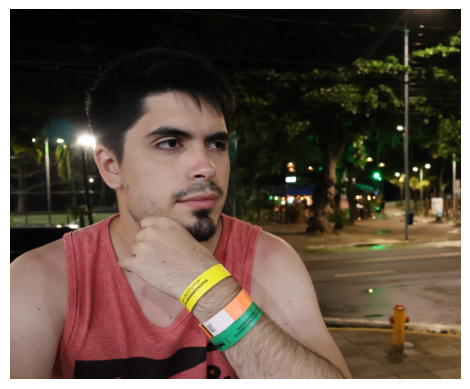

In [60]:
img = cv2.cvtColor(imgCrudo, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(img)

### 1.2 **Ejercicio 2:** Convertir la Imagen a Escala de Grises

El detector Haar necesita la imagen en escala de grises.

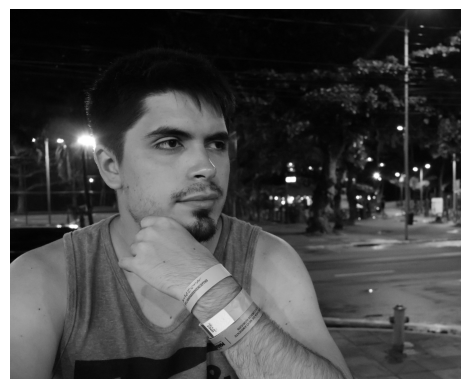

In [61]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.axis("off")
plt.imshow(img_gray, cmap="gray")

### 1.3 **Ejercicio 3:** Cargar Clasificador y Detectar Rostros

Cargamos el archivo `.xml` y usamos el método `detectMultiScale` sobre la imagen gris. Este método busca caras en diferentes tamaños y devuelve una lista de rectángulos `(x, y, ancho, alto)` por cada cara encontrada.

#### Obtenemos las cascadas de cara detectables

El uso de "cascada" en algoritmos de clasificación (AdaBoost) es un paso pre-existente en la construcción cuando trabajamos con caracteristicas de Haar

En el primer paso, se verifican ciertas caracteristicas. Si el clasificador produce una baja probabilidad de que haya un rostro, el recorte se descarta inmediatamente, evitando malgastar tiempo en regiones de la imagen sin rostro.

Esto es fundamental, ya que típicamente una imagen tendrá muy pocos recortes con presencia de rostros y gastar computo en descartarlos volvería al algoritmo muy lento.

En el caso en que el primer paso produzca una probabilidad buena, se pasa al siguiente clasificador, que, nuevamente, tiene poder de veto sobre el recorte.

In [62]:
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# Aplicamos el detector a la imagen
faces = face_cascade.detectMultiScale(img_gray)

In [63]:
# Obtenemos una cara
len(faces)

2

En la imagen solo se ve una cara reconocible, pero el algoritmo detectó una cara adicional en alguna de las partes del fondo de la imagen, lo cual puede traernos problemas en el procesamiento.

Esto puede ser ocasionado por la difuminación del fondo

In [64]:
# El resultado consiste de 4 numeros, los dos primeros especificando
# la esquina superior izquierda de la region en la que se detectó un restros
# Y los siguiente el ancho y el alto de la region

x, y, w, h = faces[1]

### 1.4 **Ejercicio 4:** Dibujar Bounding Boxes y Nombres

Visualizamos los resultados dibujando rectángulos y nombres sobre la imagen RGB.

**Tarea:** Dibuja la bounding box de la cara en rojo. Añade su nombre encima.

Tomamos como faces[1] la cara real

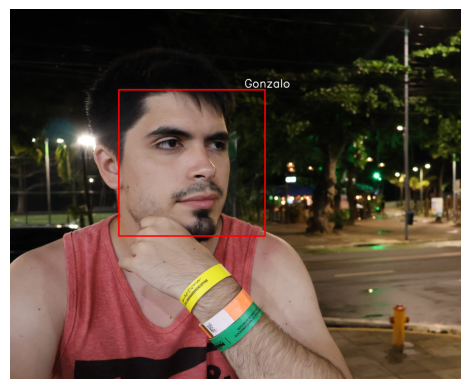

In [65]:
# Lo graficamos usando cv2.rectangle
imgRectangles = img
rectZonesFrom = (x, y)
rectZonesTo = (x+w, y+h)
rectColor = (255, 0, 0)
rectThickness = 3
cv2.rectangle(imgRectangles, rectZonesFrom, rectZonesTo, rectColor, rectThickness)

txtLabel = "Gonzalo"
txtPosition = (750, 250)
txtFont = cv2.FONT_HERSHEY_SIMPLEX
txtSize = 1.2
txtColor = (255, 255, 255)
txtThickness = 2
cv2.putText(imgRectangles, txtLabel, txtPosition, txtFont, txtSize, txtColor, txtThickness)

plt.axis("off")
plt.imshow(imgRectangles); # [:, :, [2, 1, 0]]

En la imagen reconocida podemos ver que se marcó un segundo rectángulo como una cara reconocida, cuando en realidad no tenemos una en el sector marcado.

## Sección 2: Detección de Landmarks Faciales con LBF

**Concepto:** Una vez ubicada una cara (con su bounding box), podemos usar un detector de landmarks para encontrar puntos precisos en ella. El método LBF (Local Binary Features) usa un modelo (`lbfmodel.yaml`) entrenado para localizar 68 puntos estándar en el rostro. Necesita la imagen en escala de grises y las bounding boxes como entrada.

### 2.1 Cargar Modelo y Detectar Landmarks

In [66]:
# Cargar el detector de landmarks y aplicarlo

if img_gray is not None and len(faces) > 0:
  # Creamos el detector
  landmark_detector = cv2.face.createFacemarkLBF()
  # Cargamos el modelo
  try:
    landmark_detector.loadModel("lbfmodel.yaml")
    print("Modelo LBF cargado.")

    # Aplicamos el detector ('fit')
    # Recibe la imagen GRIS y las bounding boxes 'faces'
    ok, all_landmarks = landmark_detector.fit(img_gray, faces)

    if ok:
      print(f"Se detectaron landmarks para {len(all_landmarks)} rostro(s).")
      # all_landmarks es una lista, cada elemento es un array de landmarks para una cara
    else:
      print("Error durante la detección de landmarks con .fit()")
      all_landmarks = None

  except cv2.error as e:
    print(f"Error cargando o usando el modelo LBF: {e}")
    print("Asegúrate que 'lbfmodel.yaml' se descargó correctamente.")
    all_landmarks = None
else:
  print("Se requiere la imagen gris y las caras detectadas ('faces').")
  all_landmarks = None

Modelo LBF cargado.
Se detectaron landmarks para 2 rostro(s).


### 2.2 Procesar y Visualizar Landmarks

Los landmarks vienen en un formato específico (array 3D, tipo float). Los procesamos para obtener un array 2D de enteros `(x, y)` para cada uno de los 68 puntos del rostro y los dibujamos.

Landmarks procesados. Forma: (68, 2)

Dibujando landmarks:

Zoom:
[1190  138   84   84]
[348 258 468 468]


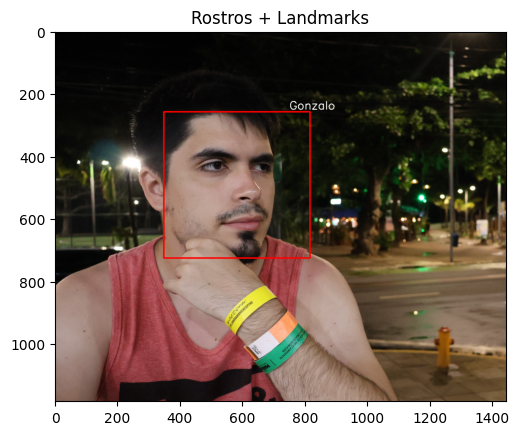

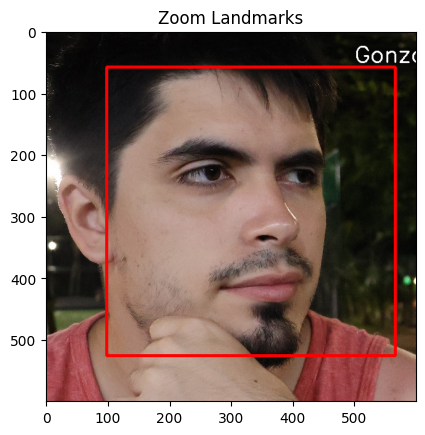

In [72]:
def dibujar():
  # Dibujar sobre la imagen 'img_rgb' (que ya tiene boxes/nombres)
  print("\nDibujando landmarks:")
  for x, y in landmarks:
      cv2.circle(img_rgb, (x, y), 0, (0, 255, 0), 1) # Radio 0, grosor 1 para punto pequeño
  plt.imshow(img_rgb)
  plt.title("Rostros + Landmarks")

  # Mostrar zoom
  print("\nZoom:")
  plt.figure()

  # [200:800, 250:850]
  print(faces[0])
  print(faces[1])
  endY = y+h
  endX = x+w

  #img_landmarks = img_rgb[y:y+h, x:x+w]
  # Por que no funciona con [y:endY, x:endX] ???
  # Me pudri de debuggear esto, no llego con los tiempos
  img_landmarks = img_rgb[200:800, 250:850]
  plt.imshow(img_landmarks)
  plt.title("Zoom Landmarks")

# Procesar y dibujar landmarks
img_rgb = imgRectangles
if all_landmarks is not None and len(all_landmarks) >= 1:
  # Landmarks del primer rostro (indice 0)
  landmarks = all_landmarks[0]
  # Quitar dimensión extra y convertir a enteros
  landmarks = landmarks[0].astype(int)
  print("Landmarks procesados. Forma:", landmarks.shape) # Debe ser (68, 2)
  dibujar()

else:
  print("No hay landmarks disponibles para procesar.")

### 2.3 **Ejercicio 5:** Procesar y Dibujar Landmarks (img_rgb)

**Tarea:** Haz lo mismo que en la celda anterior pero para el segundo rostro (Darín, índice 1) y dibuja sus landmarks en rojo sobre la *misma* imagen `img_rgb`.

In [ ]:
# Solución Ejercicio 5 (Procesar y dibujar landmarks Darín)

if all_landmarks is not None and len(all_landmarks) >= 2:
  # Procesar landmarks Darín (indice 1)
  landmarks_darin = all_landmarks[1]
  landmarks_darin = landmarks_darin[0].astype(int)
  print("Landmarks Darín procesados. Forma:", landmarks_darin.shape)

  # Dibujar sobre la imagen 'img_rgb' existente
  print("\nDibujando landmarks de Darín (rojo):")
  for x, y in landmarks_darin:
      cv2.circle(img_rgb, (x, y), 0, (255, 0, 0), 1)
  plt.imshow(img_rgb)
  plt.title("Rostros + Ambos Landmarks")

  # Mostrar zoom
  print("\nZoom en Darín:")
  plt.figure()
  plt.imshow(img_rgb[70:150, 130:190])
  plt.title("Zoom Landmarks Darín")

elif all_landmarks is None:
  print("No hay landmarks disponibles.")
elif len(all_landmarks) < 2:
  print("Solo se detectó 1 rostro, no se pueden procesar landmarks para Darín.")

## Sección 3: Selección y Aplicación de Landmarks

Conociendo el índice de cada landmark (ver imagen de la malla), podemos seleccionar y usar solo los puntos que nos interesan para tareas específicas.

### 3.1 **Ejercicio 6:** Dibujar Ojos y Boca (Pauls)

**Tarea:**
1.  Define listas con los índices correspondientes a los ojos y la boca.
2.  Crea una **copia limpia** de la imagen RGB original (`img_con_partes = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`).
3.  Itera sobre `landmarks_pauls`.
4.  Dibuja solo los puntos de ojos y boca sobre `img_con_partes` usando colores distintos (Magenta, Azul, Cian).
5.  Muestra un zoom en Pauls de la imagen resultante.

## Sección 4: Conclusión y Próximos Pasos

En este laboratorio, hemos integrado la detección de rostros con la localización de landmarks faciales usando OpenCV. Vimos cómo preparar la imagen, aplicar los detectores y visualizar los resultados, incluyendo la selección de puntos específicos.

Estos landmarks son bloques de construcción para aplicaciones más avanzadas como:
*   **Detección de Somnolencia/Bostezos:** Calculando Eye Aspect Ratio (EAR) y Mouth Aspect Ratio (MAR).
*   **Análisis de Expresiones Faciales.**
*   **Realidad Aumentada.**

**Ideas para continuar:**
*   Investiga y calcula EAR y MAR para los rostros detectados.
*   Aplica este flujo de trabajo a otras imágenes o a los fotogramas de un video.